# M2177.003100 Deep Learning <br> Assignment #4 Implementing Conditional Generative Adversarial Nets - part2 Labeld Face Data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jaeyoon Yoo, November 2017

In this notebook, you will learn how to implement conditional Genverative Adversarial Nets (cGANs) <br>
The goal here is to build GANs that draw a face given its label. You can draw a black male/black female/white male/white female as you gives an input at the end of training. <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #2:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- [4] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
- [5] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

## 0. Download and load MNIST datasets
Unzip the face_dataset.tar.gz and locate them into your data directory. Following is how to load the data. Modify  *data_dir* to be the directory the data is in. Or you will get an error.<br>

In [1]:
from utils import load_face
data_dir = './data/face_dataset'
im, label = load_face(data_dir)

There are 13143 images and corresponding lables. Labels have three values. Following is the detail:

Label1 - Male/Female : positive value means male<br>
Label2 - White/Not white : positive value means White<br>
Lable3 - Black/Not black : positive value menas black<br>
The large value represents the more property it has.

Note that the labels are not normalized and check the data by runing and modifying following code

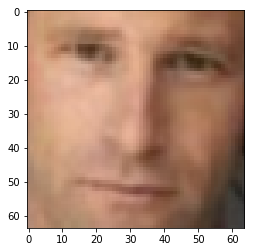

[ 1.56834639  1.73720325 -0.92972867]


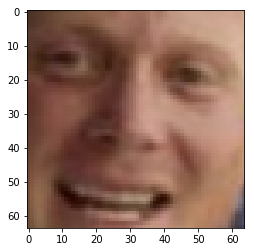

[ 0.16985062  0.42270934 -1.28218444]


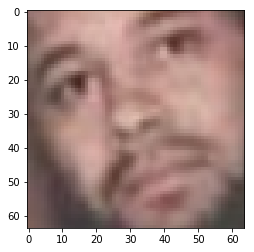

[ 0.99774898 -0.15737693 -0.75644725]


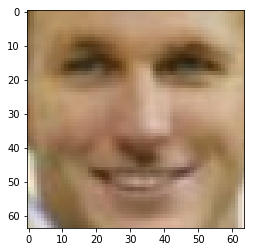

[ 1.12271853  1.91614437 -2.51421429]


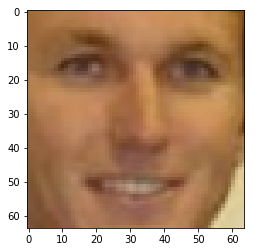

[ 1.07821424  1.67621104 -2.27805594]


In [2]:
import pylab as plt
for i in range(5):
    plt.imshow(im[i])
    plt.show()
    print(label[i])

## <a name="1"></a> 1. Building a network

In this section, you will implement neural networks for (1) generative model (2) discriminative model. You can reuse your code in part1 and improve it. Just write the code in whatever way you find most clear.

In [3]:
from utils import load_face
from utils import getNext_batch
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import sample_label_face
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

learning_rate = 0.0002
batch_size = 128
EPOCH = 300
display_step = 50
sample_size = 100
y_dim = 3
channel = 3


It is time for a generative model. You can change anything including the argument If you need. Feel free to change it and improve it.

In [4]:
def gern_net(batch_size, z , y ,sample_size, y_dim, output_size):
    with tf.variable_scope('gen'):
        #### TODO ####
        w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        w_init = tf.contrib.layers.xavier_initializer()
        b_init = tf.constant_initializer(0.0)
        
        h = tf.concat([z,y], axis=3)
        
        h = tf.layers.conv2d_transpose(h, 256, [8, 8], strides=(1, 1), padding='valid', kernel_initializer=w_init, bias_initializer=b_init)
        #h = tf.layers.batch_normalization(h, training=True)
        h = tf.nn.relu(h)
        
        h = tf.layers.conv2d_transpose(h, 196, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        #h = tf.layers.batch_normalization(h, training=True)
        h = tf.nn.relu(h)
        
        h = tf.layers.conv2d_transpose(h, 64, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        #h = tf.layers.batch_normalization(h, training=True)
        h = tf.nn.relu(h)
        
        h = tf.layers.conv2d_transpose(h, 3, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        h = tf.nn.tanh(h)
        
    ####TODO ####
    out = h
    return out


Now, it's time for a discriminative model. Again, you can change anything if you need

In [5]:
def dis_net(data_array , y, reuse=False):
    with tf.variable_scope('dis',reuse=reuse):
        #### TODO ####
        batch_size = data_array.shape[0]
        
        w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        w_init = tf.contrib.layers.xavier_initializer()
        b_init = tf.constant_initializer(0.0)
        
        h = tf.concat([data_array, y], axis=3)
        
        h = tf.layers.conv2d(h, 64, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        h = tf.nn.leaky_relu(h)
        
        h = tf.layers.conv2d(h, 196, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        #h = tf.layers.batch_normalization(h, training=True)
        h = tf.nn.leaky_relu(h)
        
        h = tf.layers.conv2d(h, 256, [5, 5], strides=(2, 2), padding='same', kernel_initializer=w_init, bias_initializer=b_init)
        #h = tf.layers.batch_normalization(h, training=True)
        h = tf.nn.leaky_relu(h)
        
        ###
        #h = tf.layers.conv2d(h, 72, [8, 8], strides=(1, 1), padding='valid', kernel_initializer=w_init, bias_initializer=b_init)
        #h = tf.nn.leaky_relu(h)
        
        #h = tf.squeeze(tf.squeeze(h, axis=1), axis=1)
        #h = tf.layers.dense(h, 1, kernel_initializer=w_init)
        
        h = tf.layers.conv2d(h, 1, [8, 8], strides=(1, 1), padding='valid', kernel_initializer=w_init)
        h = tf.squeeze(tf.squeeze(h, axis=1), axis=1)
        
    #### TODO ####
    out = h
    return tf.nn.sigmoid(out), out



## <a name="2"></a> 2. Build a main part and train

In this section, you will implement the main part. Then run the code and check the model draws the face properly.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test' directory that resulting image will be saved in. You can change the directory as you want.

In [6]:
from utils import load_mnist
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

learning_rate = 0.0002
batch_size = 128
EPOCH = 300
display_step = 50
sample_size = 100
y_dim = 3
channel = 3
output_size = 64
sample_dir = 'samples_for_test'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Feel free to fill in the main part. You can copy the part1 code or write your own code.

Your goal is to **generate 4 row and 8 column images(32 total)**.

**Each row should correspond to each label**.

First row : black male<br>
Second row: black female<br>
Third row : white male<br>
Fourth row: white female<br>

You can use "save_images" method in *utils.py* to align generated image by 4*8. See part1 code to get how to use it.

You must show **at least three generated images**. (At the beginning of ,in the midway of, at the end of training.)


EPOCH 0 step 100: D: loss = 1.1438241 G: loss=0.8745830 


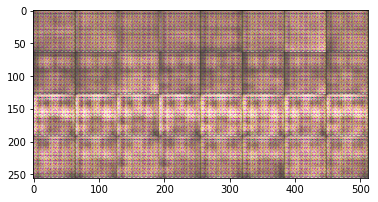

EPOCH 1 step 200: D: loss = 1.2280755 G: loss=0.8261040 
EPOCH 2 step 300: D: loss = 1.3826833 G: loss=0.6051740 
EPOCH 3 step 400: D: loss = 1.2004797 G: loss=0.9002272 
EPOCH 4 step 500: D: loss = 1.2810917 G: loss=0.7447290 
EPOCH 5 step 600: D: loss = 1.2159505 G: loss=0.6851816 
EPOCH 6 step 700: D: loss = 1.2022732 G: loss=0.9007156 
EPOCH 7 step 800: D: loss = 1.2486523 G: loss=0.7102692 
EPOCH 8 step 900: D: loss = 1.2086890 G: loss=0.8220570 
EPOCH 9 step 1000: D: loss = 1.4069798 G: loss=0.8256658 
EPOCH 10 step 1100: D: loss = 1.5221530 G: loss=0.6735493 
EPOCH 11 step 1200: D: loss = 1.2042781 G: loss=0.7896036 
EPOCH 12 step 1300: D: loss = 1.1216173 G: loss=0.8664842 
EPOCH 13 step 1400: D: loss = 1.1662321 G: loss=0.9154165 
EPOCH 14 step 1500: D: loss = 1.2783130 G: loss=0.8577378 
EPOCH 15 step 1600: D: loss = 1.1543407 G: loss=0.7686163 
EPOCH 16 step 1700: D: loss = 1.0082997 G: loss=0.8925639 
EPOCH 17 step 1800: D: loss = 1.3006865 G: loss=0.8559294 
EPOCH 18 step 

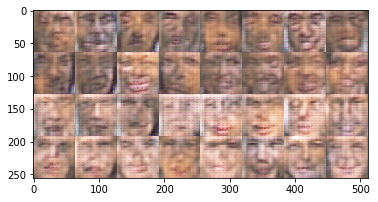

EPOCH 23 step 2400: D: loss = 1.2437292 G: loss=0.7466673 
EPOCH 24 step 2500: D: loss = 1.2174554 G: loss=0.8645260 
EPOCH 25 step 2600: D: loss = 1.2670822 G: loss=0.7211517 
EPOCH 26 step 2700: D: loss = 1.3432271 G: loss=0.7088321 
EPOCH 27 step 2800: D: loss = 1.2978125 G: loss=0.7435724 
EPOCH 28 step 2900: D: loss = 1.3529792 G: loss=0.7072364 
EPOCH 29 step 3000: D: loss = 1.4099858 G: loss=0.7217650 
EPOCH 30 step 3100: D: loss = 1.2782494 G: loss=0.6631380 
EPOCH 31 step 3200: D: loss = 1.3179992 G: loss=1.0247335 
EPOCH 32 step 3300: D: loss = 1.3880796 G: loss=0.6585267 
EPOCH 33 step 3400: D: loss = 1.1957546 G: loss=0.8531146 
EPOCH 34 step 3500: D: loss = 1.3331144 G: loss=0.8314158 
EPOCH 35 step 3600: D: loss = 1.2274725 G: loss=0.7697307 
EPOCH 36 step 3700: D: loss = 1.2579906 G: loss=0.8905747 
EPOCH 37 step 3800: D: loss = 1.2995102 G: loss=0.8329972 
EPOCH 38 step 3900: D: loss = 1.3970842 G: loss=0.6645616 
EPOCH 39 step 4000: D: loss = 1.3492355 G: loss=0.715314

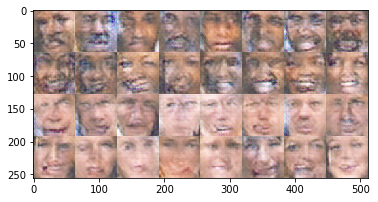

In [7]:
#### TODO ####
import time
sample_z = np.random.uniform(-1 , 1 , size = [batch_size , 1, 1, sample_size])
y = tf.placeholder(tf.float32, [None , 1, 1, y_dim])
y_expand = tf.placeholder(tf.float32, [None , output_size, output_size, y_dim])
images = tf.placeholder(tf.float32, [batch_size, output_size, output_size, channel])
z = tf.placeholder(tf.float32, [None , 1, 1, sample_size])
fake_images = gern_net(batch_size, z , y ,sample_size, y_dim,output_size)

##the loss of gerenate network
D_pro , D_logits = dis_net(images, y_expand ,  False)
G_pro, G_logits = dis_net(fake_images , y_expand , True)

# DEFINE LOSS FUNCTION #
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits, labels=tf.ones([batch_size, 1])))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits, labels=tf.zeros([batch_size, 1])))

D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits, labels=tf.ones([batch_size, 1])))

t_vars = tf.trainable_variables()

d_var = [var for var in t_vars if 'dis' in var.name]
g_var = [var for var in t_vars if 'gen' in var.name]

opti_D = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(D_loss , var_list=d_var)
opti_G = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(G_loss , var_list=g_var)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def sample_label_face2(num):
    label_vector = np.zeros((num,3))
    #Label1 - Male/Female : positive value means male
    #Label2 - White/Not white : positive value means White
    #Lable3 - Black/Not black : positive value menas black
    for i in range(num):
        if i % 4 == 0:
            #First row : black male
            label_vector[i] = [2, -2, 2]
        elif i % 4 == 1:
            #Second row: black female
            label_vector[i] = [-2, -2, 2]
        elif i % 4 == 2:
            #Third row : white male
            label_vector[i] = [2, 2, -2]
        elif i % 4 == 3:
            #Fourth row: white female
            label_vector[i] = [-2, 2, -2]
            
    return label_vector
    

with tf.Session(config=config) as sess:

    sess.run(init)
    e = 0
    step = 0

    start_time = time.time()
    middle_printed = False
    start_printed = False
    
    def print_images():
        sample_label = sample_label_face2(batch_size)
        sample_label = np.reshape(sample_label, [batch_size, 1, 1, y_dim])
        sample_label_expand = sample_label * np.ones([batch_size, output_size, output_size, y_dim])

        sample_images = sess.run(fake_images , feed_dict={z:sample_z , y:sample_label, y_expand:sample_label_expand})
        sample_images = sample_images[:32,:,:,:]
        image_name = './{}/face_train_{:02d}_{:04d}.png'.format(sample_dir , e , step)
        save_images(sample_images , [4,8] , image_name)

        img = mpimg.imread(image_name)
        imgplot = plt.imshow(img)
        plt.show()
        
    while e <= EPOCH:
        batch_num = 0
        
        while batch_num < len(im) / batch_size - 1:

            step = step + 1

            realbatch_array , real_labels = getNext_batch(im , label , batch_num, batch_size)
            real_labels = np.reshape(real_labels, [batch_size, 1, 1, y_dim])
            real_labels_expand = real_labels * np.ones([batch_size, output_size, output_size, y_dim])
            
            #Get the z
            batch_z = np.random.uniform(-1 , 1 , size=[batch_size , 1, 1, sample_size])

            _ = sess.run(opti_D, feed_dict={images:realbatch_array, z:batch_z , y:real_labels, y_expand:real_labels_expand})
            _ = sess.run(opti_G, feed_dict={z: batch_z , y:real_labels, y_expand:real_labels_expand})

            batch_num += 1

            if step % 100 == 0:
                d_get_loss = sess.run(D_loss , feed_dict = {images:realbatch_array , z:batch_z, y:real_labels , y_expand:real_labels_expand})
                g_get_loss = sess.run(G_loss , feed_dict = {z: batch_z , y:real_labels, y_expand:real_labels_expand})
                print("EPOCH %d step %d: D: loss = %.7f G: loss=%.7f " % (e , step , d_get_loss , g_get_loss))
                
            if (not start_printed and e > 0) or (not middle_printed and (time.time() - start_time > (60*5))):
                print_images()
                
                if not start_printed:
                    start_printed = True
                else:
                    middle_printed = True
                
            if time.time() - start_time > (60*10):
                break
                
        e = e + 1
        batch_num = 0
        
        if time.time() - start_time > (60*10):
            print_images()
            break

        